In [20]:
import janitor

In [1]:
data = '/Users/zwl/data/etf.h5'
px = pd.read_hdf(data, key='close')

In [2]:
px.head()

,IEML LN Equity,HYG US Equity,IHYU LN Equity,SPY US Equity,EMB US Equity,EEM US Equity,LQD US Equity,IEF US Equity,IEI US Equity,SHY US Equity,IHYG LN Equity
index,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,101.8675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,97.8838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,98.0589,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,96.4830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,102.0863,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
import pypbo.perf as perf

In [13]:
rtns = perf.log_returns(px)

In [17]:
rtns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4854 entries, 2000-01-03 to 2019-02-08
Data columns (total 11 columns):
IEML LN Equity    1932 non-null float64
HYG US Equity     2979 non-null float64
IHYU LN Equity    1872 non-null float64
SPY US Equity     4805 non-null float64
EMB US Equity     2802 non-null float64
EEM US Equity     3984 non-null float64
LQD US Equity     4163 non-null float64
IEF US Equity     4163 non-null float64
IEI US Equity     3040 non-null float64
SHY US Equity     4163 non-null float64
IHYG LN Equity    2130 non-null float64
dtypes: float64(11)
memory usage: 455.1 KB


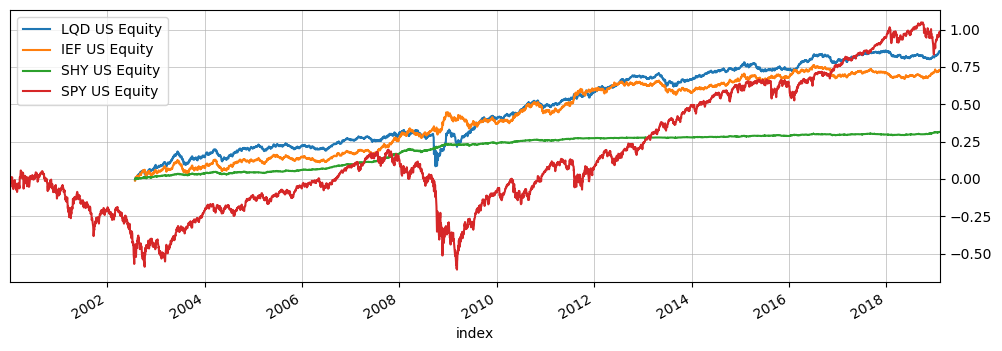

In [19]:
rtns[['LQD US Equity', 'IEF US Equity', 'SHY US Equity', 'SPY US Equity']].cumsum().plot()

In [4]:
import sys

In [5]:
sys.path.insert(0, '/Users/zwl/git/mlstack')

In [6]:
import mlstack.tscv as tscv

In [14]:
dfl = tscv.wide_to_long(rtns)

In [15]:
dfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36033 entries, 0 to 36032
Data columns (total 3 columns):
index    36033 non-null datetime64[ns]
name     36033 non-null object
value    36033 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ MB


In [16]:
dfl.head()

,index,name,value
0,2003-04-14,EEM US Equity,0.012899
1,2003-04-15,EEM US Equity,0.011805
2,2003-04-16,EEM US Equity,0.011553
3,2003-04-17,EEM US Equity,0.007096
4,2003-04-21,EEM US Equity,-0.000342


In [21]:
feat_cols = ['LQD US Equity', 'IEF US Equity', 'EEM US Equity', 'SPY US Equity']

In [43]:
x = rtns[feat_cols].dropna(how='all')

In [44]:
flag = x.isnull().any(axis=1)

In [45]:
x.loc[flag].tail()

,LQD US Equity,IEF US Equity,EEM US Equity,SPY US Equity
index,,,,
2003-04-07,-0.001828,-0.002340,NaN,-0.001929
2003-04-08,0.003654,0.003741,NaN,0.001589
2003-04-09,0.003277,0.003380,NaN,-0.013240
2003-04-10,-0.003642,-0.002680,NaN,0.005499
2003-04-11,-0.003563,-0.002570,NaN,-0.004122


In [46]:
# safe to drop other NaN
x = x.dropna(how='any')

In [47]:
x = janitor.clean_names(x)

In [48]:
x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3984 entries, 2003-04-14 to 2019-02-08
Data columns (total 4 columns):
lqd_us_equity    3984 non-null float64
ief_us_equity    3984 non-null float64
eem_us_equity    3984 non-null float64
spy_us_equity    3984 non-null float64
dtypes: float64(4)
memory usage: 155.6 KB


In [49]:
# now convert to sequence examples (t, dim)
seq_len = 12
dim = x.shape[1]

In [50]:
num_train = len(x) // seq_len
tail = len(x) % seq_len

In [51]:
num_train, tail

(332, 0)

In [52]:
# remove tail
if tail > 0:
    x = x.iloc[:-tail]
len(x)

3984

In [53]:
xx = x.values.reshape((-1, seq_len, dim))

In [54]:
xx.shape

(332, 12, 4)

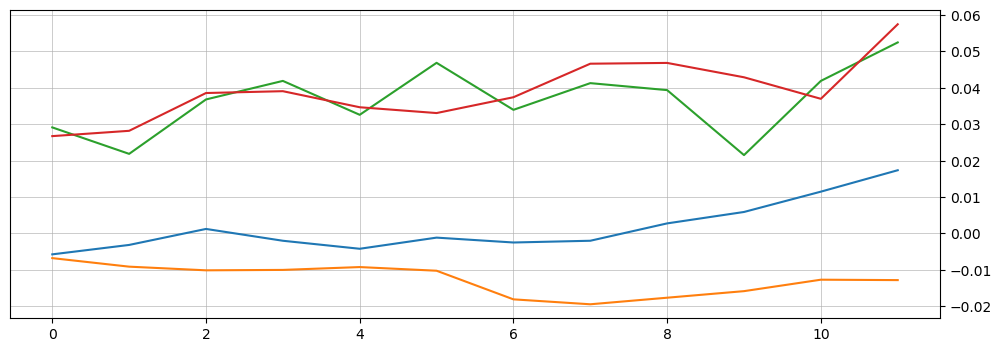

In [62]:
# long at random slice
plt.plot(range(12), xx[105].cumsum(axis=0))

In [63]:
import torch
import torch.nn as nn

In [64]:
sys.path.insert(0, '/Users/zwl/git/former/')

In [66]:
from former.transformers import CTransformer

In [67]:
device = 'cpu'

In [69]:
pos_embedding = nn.Embedding(embedding_dim=1, num_embeddings=seq_len)

In [79]:
emb = pos_embedding(torch.arange(seq_len, device=device))
emb.shape

torch.Size([12, 1])

In [80]:
emb[None, :, :].shape

torch.Size([1, 12, 1])

In [83]:
# convert to batch format
emb[None, :, :].expand(16, seq_len, 1).shape

torch.Size([16, 12, 1])